## Imports

In [1]:
import numpy as np
import nibabel as nib
import cv2
from skimage import morphology, measure
from skimage.segmentation import watershed
from skimage import filters
from scipy import ndimage
import matplotlib.pyplot as plt
# from pycimg import CImg


## Load / save .nii files and Visualization

In [2]:
def load_nii_gz_file(file_path: str) -> tuple:
    nii_img = nib.load(file_path)
    nii_data = nii_img.get_fdata()
    return nii_data, nii_img.affine

def save_to_nii(segmented_data: np.ndarray, affine: np.ndarray, output_path: str) -> None:
    segmented_nii = nib.Nifti1Image(segmented_data.astype(np.uint8), affine)
    nib.save(segmented_nii, output_path)
    
def view_nii_data(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def visualize_photos(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, slice_num: int=50) -> None:
    plt.figure(figsize=(15, 5))
    # Original slice
    plt.subplot(1, 3, 1)
    plt.title("Original Slice")
    plt.imshow(original[:, :, slice_num], cmap="gray")
    # Segmented slice
    plt.subplot(1, 3, 2)
    plt.title("Segmented Slice")
    plt.imshow(segmented[:, :, slice_num], cmap="gray")
    # Reference slice
    plt.subplot(1, 3, 3)
    plt.title("Reference Slice")
    plt.imshow(reference[:, :, slice_num], cmap="gray")
    
    plt.show()

## Segmentation

In [3]:
def binarize_image(image: np.ndarray, threshold: float = -320, use_otsu: bool = False) -> np.ndarray:
    threshold = filters.threshold_otsu(image) if use_otsu else threshold
    image = image < threshold
    return image

def apply_body_mask(base_img: np.ndarray, body_mask: np.ndarray) -> np.ndarray:
    base_img = base_img * body_mask
    return base_img

In [4]:
def transform(img: np.ndarray, min_lung_size: int = 1000) -> np.ndarray:
    img = morphology.binary_dilation(img, morphology.ball(3))
    img = morphology.binary_erosion(img, morphology.ball(3))

    img_filled = ndimage.binary_fill_holes(img)
    # label connected components
    labeled_air, num_labels = ndimage.label(img_filled)
    lung_candidates = morphology.remove_small_objects(labeled_air, min_size=min_lung_size)

    lungs_mask = lung_candidates > 0
    return lungs_mask.astype(np.uint8)


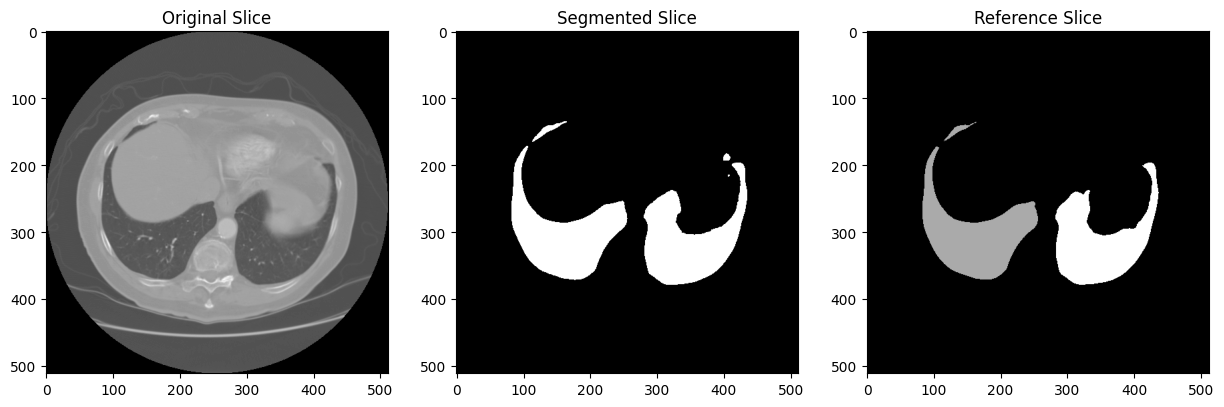

In [5]:
def main(img_path: str,reference_img_path: str, body_mask_path: str, output_path: str, ) -> None:
    # load images
    img, affine = load_nii_gz_file(img_path)
    body_mask, _ = load_nii_gz_file(body_mask_path)
    reference_img, _ = load_nii_gz_file(reference_img_path)

    # transform
    img_transform = binarize_image(img, use_otsu=False)
    img_transform = apply_body_mask(img_transform, body_mask)
    img_transform = transform(img_transform)
    visualize_photos(img, img_transform, reference_img)


main('Images/IMG_0001.nii.gz','ReferenceSegmentations/LUNGS_IMG_0001.nii.gz', 'BodyMasks/BODYMASK_IMG_0001.nii.gz', 'output.nii.gz')
